<h1>Introduction</h1>

This tutorial demonstrate how to compute a kinematic electron difraction pattern simulation of a crystal structure (Graphite).

<h1>Creation of the crystial structure</h1>

For the creation of the crystal structure we will use the library diffsims. 
​
There are two forms of creating this crystal: the first is the hard way, in which we will need to import the correct librarys and use the basic codes to build up the graphite. And, there is the easy way, in which all we are going to need is go to https://github.com/pyxem/diffsims-demos and copy the crystal they had made.

Let's start with the hard way, obviously.

In [ ]:
pip install diffsims

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install SciencePlots

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import diffsims as ds
import diffpy.structure
from diffpy.structure.expansion import supercell

from diffsims.utils.fourier_transform import get_recip_points
from diffsims.utils.probe_utils import BesselProbe
from diffsims.utils.discretise_utils import get_discretisation
from diffsims.generators.diffraction_generator import AtomicDiffractionGenerator

import numpy as np
import scipy as sp
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
import imageio
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from matplotlib.animation import PillowWriter
import pint

plt.style.use(['science', 'notebook'])
u = pint.UnitRegistry()

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


Now that we had installed the libraries what we are going to do is create a lattice structure in which the atoms will be distributed. For this, take the code diffpy.structure.lattice.Lattice(a,b,c,alpha,beta,gamma,baserot,base) since this is the one in charge of create the structure of the lattice by spicifying the lenghts a, b and c of a unit cell and the angles alpha (between b and c axes in degrees), beta (between a and c axes in degrees) and gamma (between a and b axes in degrees). 

In [ ]:
latt = diffpy.structure.lattice.Lattice(5.43,5.43,5.43,90,90,90)

Thus, you must define how te atoms will be organize over the space. 
Is in this point that the lattice structure need to be use because is in the structure that the atoms are going to be placed by the code diffpy.structure.atom.Atom(atype=None, xyz=None, label=None, occupancy=None, anisotropy=None, U=None, Uisoequiv=None, lattice=None), where the space "atype" let us to spicify the string type of the atom, that is the atom type or the element symbol. Now, the space "xyz" let us to take, within the lattice we created, a certain coordinate system called fractional coordinates in which the edges of the unit cell are used as the basic vectors. So, in every edge is placed an atom.  

In [ ]:
atom = diffpy.structure.atom.Atom(atype='Si',xyz=[0,0,0],lattice=latt)

In this point is only left combine the last two codes and generate a crystalline structure. 

In [ ]:
structure = diffpy.structure.Structure(atoms=[atom],lattice=latt)

Now, what we want to do is to generate a diffraction pattern by pass through the crystall a beam of electrons. This pattern arises when the electrons are being considerate as waves taking the momentum as a measure of the frequency of this oscillation $\lambda=\frac{h}{mv}$, where $\textit{h}$ is the Planck's constant and the product $\textit{mv}$ is the electron's momentum (Louis de Broglie). Now, we can consider that each atom of the lattice act like a diffraction point making the electron to be reflected in an angle equal to the incidence angle.
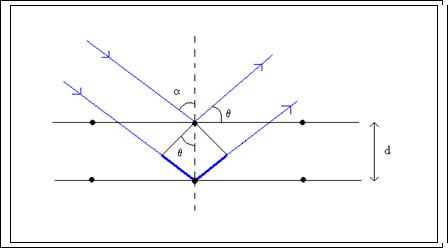


But, ¿what really happens when the beam of electrons stryke the atom?. Well, by Huygens's principle, it is know that the beam will generate a circular wave center in the atom. Can be deduced that the upper beam will generate this wave first than the downwards, and in the points where this circles overlap is where the interference is constructive. Finally, it can be probe that the angle in wich this beams are generating overlapping circles is the same angle of incidence, for atoms in the same plane. And, for atoms in different planes it is also in the same angle but not in all cases, just in which de Bragg's condition is satisfied. 



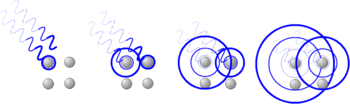

Thinking in the blue lines of the image as the electron's wave, is easy to observe that the two beams will make a constructive interference when the path of the second beam (the one that impacts the atom on the plane below) is equal to n times the wavelenght where n=0,1,2,3,4,5... and this is the basis of the Bragg's condition. 

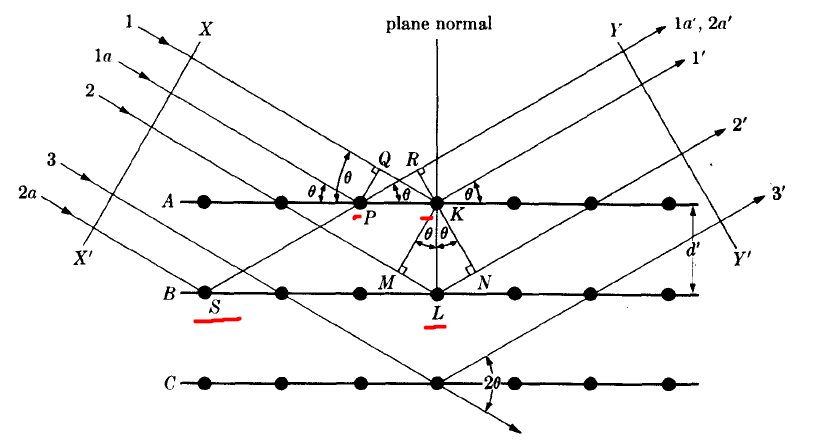

You can consult the demostration or doing it by your own, i will just put it like: the Bragg condition stablishes that the beams in different planes will generate constructive interference when the incidense angle satisfied $n\lambda=dsen(2\theta)$.

In the courses guide the angle is taken as $2\theta$ since the experimental setup generate a group of electron beams, which impact whit a plane that is inclined in a $\theta$ angle, so the difracted beam will differ from the original in a $2\theta$ angle.

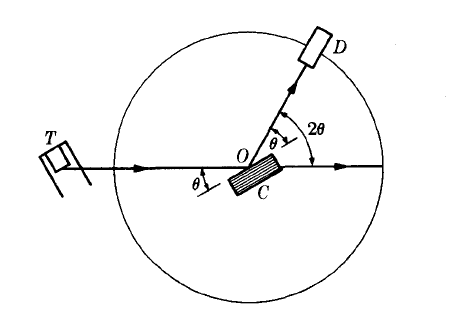

Now, coming back to the lattice, we'd created a created a crystall structure of one unit cell, but is needed a structrure that can take the major quantity of beams. So we take our unit cell and expand it all over the space with the code $\textit{supercell(structure, (70, 70, 30))}$, which make a mesh of 70x70x30 in the space acording with the conditions speficied before in the creatio  of the lattice. 

In [ ]:
structure = supercell(structure, (40, 40, 40))

And, since is needed to put this lattice of atoms in a meshgrid, we define the center of this structure so is posible to take a origin. The code structure.xyz_cartn let us to past the points in where the atoms are placed to an array, and the .max(0) give the maximum value of each column of the matrix give by this array, since each column represent one coordenate (x,y,z) by taking the half of the maximum value we have the aproximate center of the crystal.

In [ ]:
c = structure.xyz_cartn.reshape(-1,3).max(0)/2 

In [ ]:
c

array([105.885, 105.885, 105.885])

<function matplotlib.pyplot.show(close=None, block=None)>

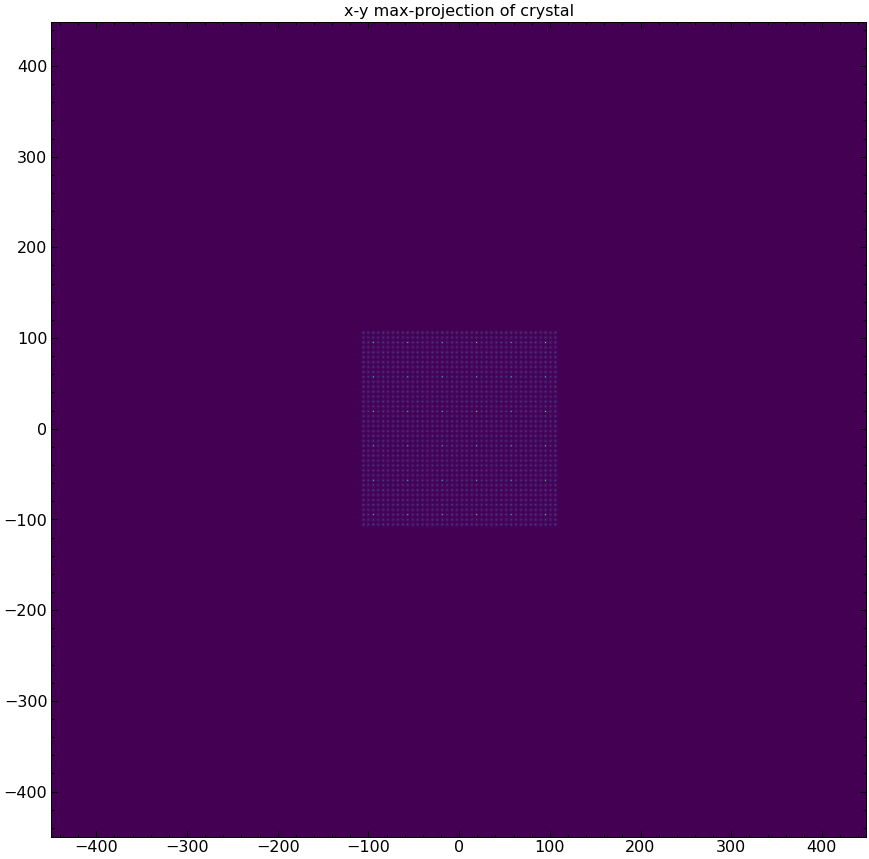

In [ ]:
x = get_recip_points(3, dX=1, rX=900)[0]
vol = get_discretisation(structure.xyz_cartn-c, 14, x, pointwise=True, ZERO=1e-5)
vol /= vol.max()
#p_vol = vol*2*probe(x)
plt.figure('volume', figsize=(15,15))
#mid = tuple(s//2 for s in vol.shape)
#plt.subplot(211)
#plt.plot(x[0],vol.max((1,2)), x[0],p_vol.max((1,2)), x[0], 2*probe(x)[:,mid[1],mid[2]])
#plt.legend(('Atomic intensities', 'Probe intensity', 'Iluminated atomic intensities'), loc='upper right')
#plt.title('Max-projection of crystal')
#plt.subplot(223)
plt.imshow(vol.max(2)**.4, aspect='equal', origin='lower', extent=[x[0][0], x[0][-1], x[1][0], x[1][-1]])
plt.title('x-y max-projection of crystal')
plt.show
#plt.imshow(p_vol.max(2)**0.1, aspect='equal', origin='lower', extent=[x[0][0], x[0][-1], x[1][0], x[1][-1]])
#plt.title('x-y max-projection of illuminated crystal')
#plt.tight_layout()

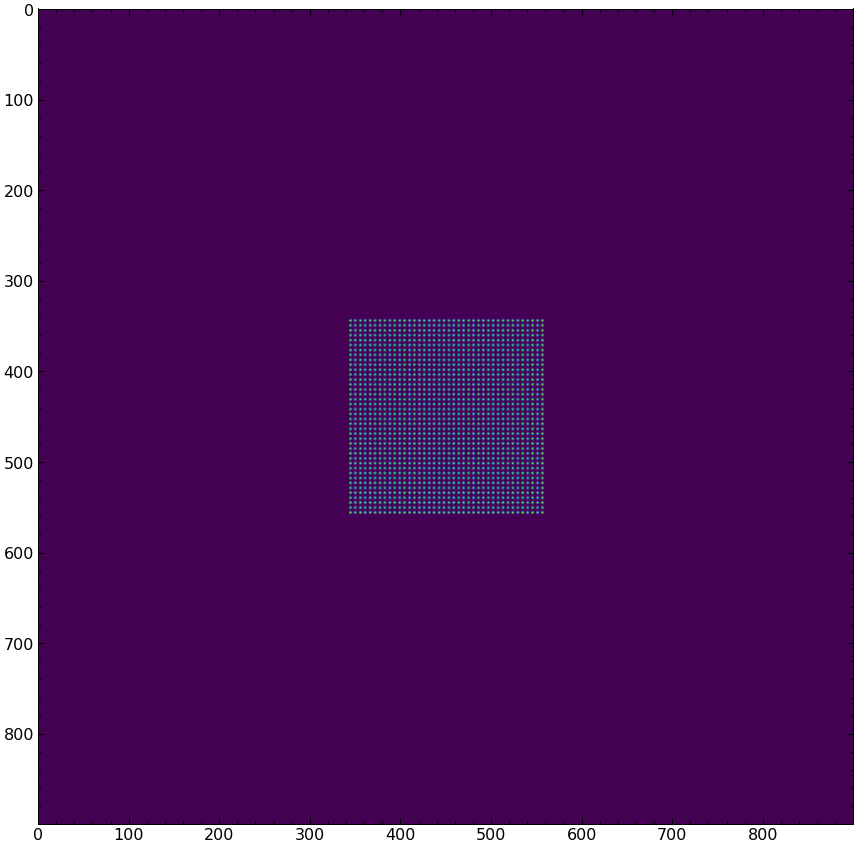

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(vol[:,:,400])

In [ ]:
D = 0.1 * u.mm
λ1 = 645 *u.nm
λ2 = 510 * u.nm
λ3 = 440 * u.nm

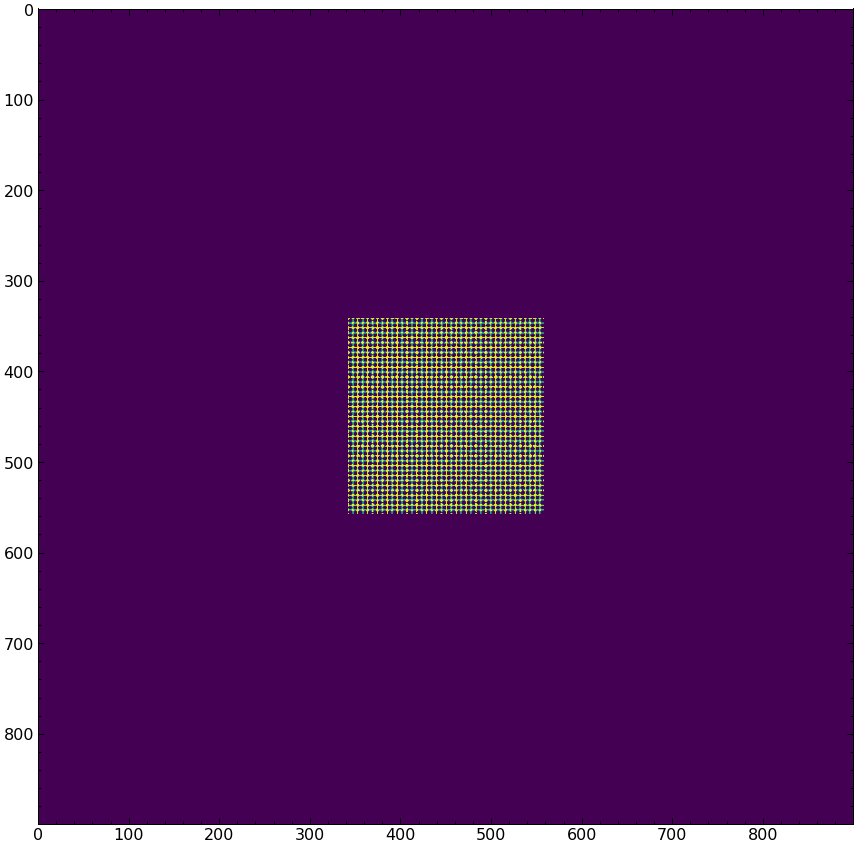

In [ ]:
grid= vol[:][:][400]==0
grid[:342][:]=0
grid[:,:342]=0
grid[558:][:]=0
grid[:,558:]=0
plt.figure(figsize=(15,15))
plt.imshow(grid)

In [ ]:
U0=grid
U0 = U0.astype(float)
U0=U0*u.mm*0.01
#x=np.linspace(-4,4,3200)*u.mm

In [ ]:
A = fft2(U0)
kx = fftfreq(len((x[0]+450)*u.mm*0.01), np.diff((x[0]+450)*u.mm*0.01)[0]) * 2 * np.pi 
kxv, kyv = np.meshgrid(kx,kx)
xv,yv=np.meshgrid((x[0]+450)*u.mm*0.01,(x[0]+450)*u.mm*0.01)

/usr/local/lib/python3.7/dist-packages/scipy/fft/_pocketfft/helper.py:98: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(x, dtype=dtype, copy=copy)


In [ ]:
def get_U(z,k):
    return ifft2(A*np.exp(1j*z*np.sqrt(k**2-kxv**2-kyv**2)))

In [ ]:
k1 = 2*np.pi/λ1
k2 = 2*np.pi/λ2
k3 = 2*np.pi/λ3
d = 3* u.cm

In [ ]:
U1 = get_U(d,k1)
U2 = get_U(d,k2)
U3 = get_U(d,k3)
U = np.zeros( (U1.shape[0],U1.shape[1],3)) # Imagen vacía
U[:,:,0] = np.abs(U1) # Parte roja de la imagen 
U[:,:,1] = np.abs(U2) # Parte verde de la imagen
U[:,:,2] = np.abs(U3) # Parte azul de la imagen 
umbral = np.max(U)
U = U/umbral

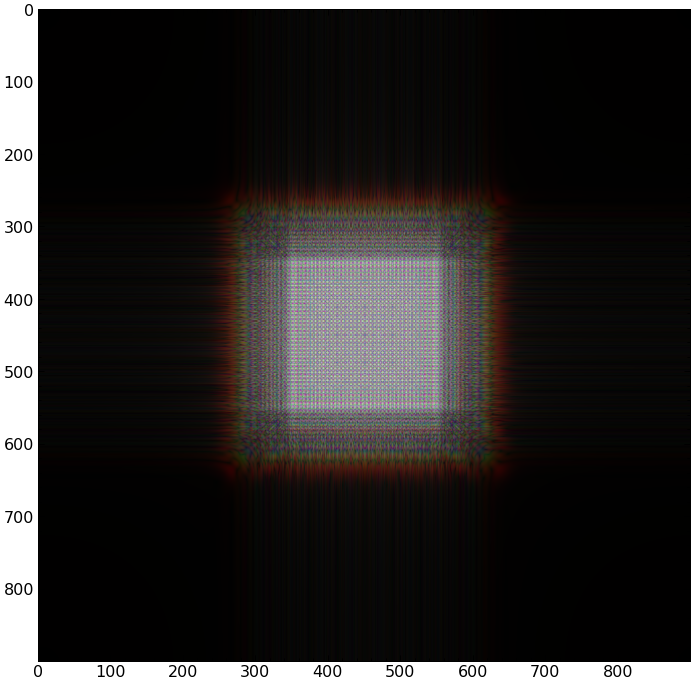

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.sqrt(np.abs(U)))

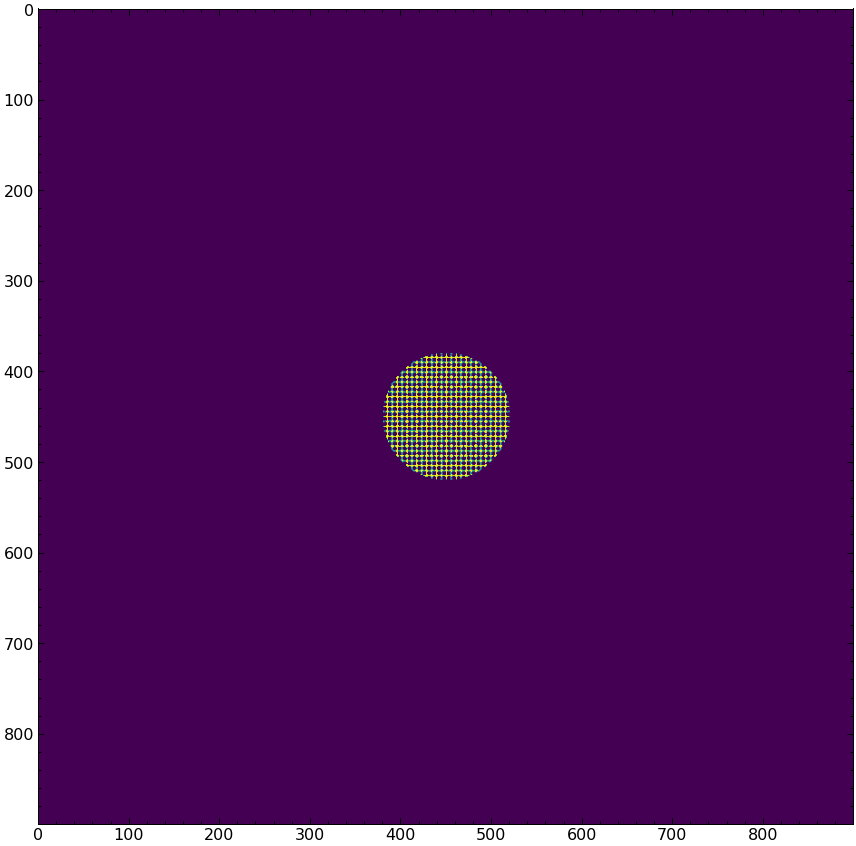

In [ ]:
grid= vol[:][:][400]==0
grid[:342][:]=0
grid[:,:342]=0
grid[558:][:]=0
grid[:,558:]=0
f=(yv-4.50*u.mm)**2+(xv-4.50*u.mm)**2
grid2= f>=(70*u.mm*0.01)**2
plt.figure(figsize=(15,15))
#plt.imshow(grid)
grid3=grid2+grid

for i in range(len(grid3[0])):
  j=0
  for j in range(len(grid3[0])):
    if (i-450)**2+(j-450)**2>=(70)**2:
      grid3[i][j]=0
plt.imshow(grid3)


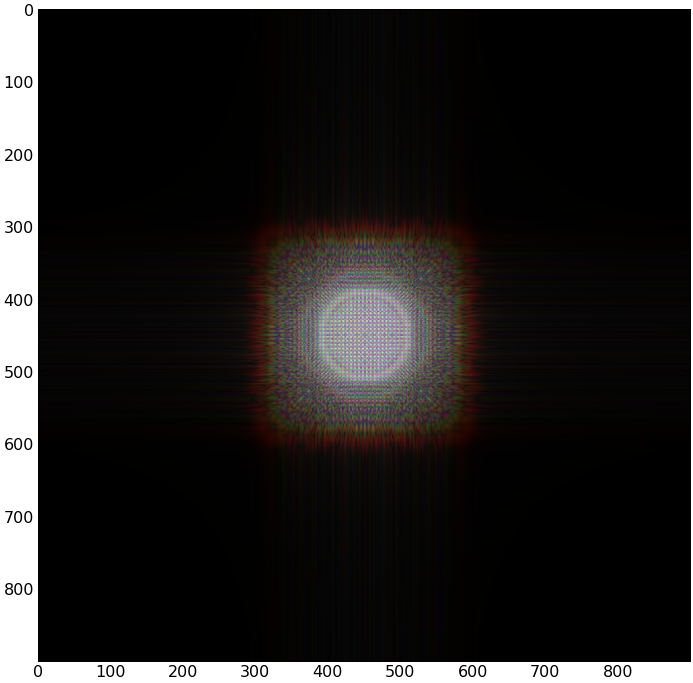

In [ ]:
U0=grid3
U0 = U0.astype(float)
U0=U0*u.mm*0.01
#x=np.linspace(-4,4,3200)*u.mmlt.imshow(grid2+grid)
A = fft2(U0)
kx = fftfreq(len((x[0]+450)*u.mm*0.01), np.diff((x[0]+450)*u.mm*0.01)[0]) * 2 * np.pi 
kxv, kyv = np.meshgrid(kx,kx)
xv,yv=np.meshgrid((x[0]+450)*u.mm*0.01,(x[0]+450)*u.mm*0.01)
def get_U(z,k):
    return ifft2(A*np.exp(1j*z*np.sqrt(k**2-kxv**2-kyv**2)))
k1 = 2*np.pi/λ1
k2 = 2*np.pi/λ2
k3 = 2*np.pi/λ3
d = 3* u.cm
U1 = get_U(d,k1)
U2 = get_U(d,k2)
U3 = get_U(d,k3)
U = np.zeros( (U1.shape[0],U1.shape[1],3)) # Imagen vacía
U[:,:,0] = np.abs(U1) # Parte roja de la imagen 
U[:,:,1] = np.abs(U2) # Parte verde de la imagen
U[:,:,2] = np.abs(U3) # Parte azul de la imagen 
umbral = np.max(U)
U = U/umbral
plt.figure(figsize=(12,12))
plt.imshow(np.sqrt(np.abs(U)))

In [ ]:
def Luz(grid):
  U0=grid
  U0 = U0.astype(float)
  U0=U0*u.mm*0.01
  λ1 = 645 
  λ2 = 510
  λ3 = 440 
  A = fft2(U0)
  kx = fftfreq(len((r[1][0]+len(r[1][0])/2)*u.mm*0.01), np.diff((r[1][0]+len(r[1][0]/2))*u.mm*0.01)[0]) * 2 * np.pi 
  kxv, kyv = np.meshgrid(kx,kx)
  xv,yv=np.meshgrid((r[1][0]+len(r[1][0])/2)*u.mm*0.01,(r[1][0]+len(r[1][0])/2)*u.mm*0.01)
  def get_U(z,k):
    return ifft2(A*np.exp(1j*z*np.sqrt(k**2-kxv**2-kyv**2)))
  k1 = 2*np.pi/(λ1*u.nm)
  k2 = 2*np.pi/(λ2*u.nm)
  k3 = 2*np.pi/(λ3*u.nm)
  d = 3* u.cm
  U1 = get_U(d,k1)
  U2 = get_U(d,k2)
  U3 = get_U(d,k3)
  U = np.zeros( (U1.shape[0],U1.shape[1],3)) # Imagen vacía
  U[:,:,0] = np.abs(U1) # Parte roja de la imagen 
  U[:,:,1] = np.abs(U2) # Parte verde de la imagen
  U[:,:,2] = np.abs(U3) # Parte azul de la imagen 
  umbral = np.max(U)
  U = U/umbral
  plt.figure(figsize=(12,12))
  plt.imshow(np.sqrt(np.abs(U)))

In [ ]:
def print_grid(x,y,z,a,b,c,dx,rx,e,f,g):
  latt = diffpy.structure.lattice.Lattice(x,y,z,a,b,c)
  atom = diffpy.structure.atom.Atom(atype='Si',xyz=[0,0,0],lattice=latt)
  structure = diffpy.structure.Structure(atoms=[atom],lattice=latt)
  structure = supercell(structure, (e, f, g))
  x = get_recip_points(3, dX=dx, rX=rx)[0]
  vol = get_discretisation(structure.xyz_cartn-c, 14, x, pointwise=True, ZERO=1e-5)
  vol /= vol.max()
  grid=vol.max(2)**.4
  plt.figure('volume', figsize=(15,15))
  plt.imshow(vol.max(2)**.4, aspect='equal', origin='lower', extent=[x[0][0], x[0][-1], x[1][0], x[1][-1]])
  plt.title('x-y max-projection of crystal')
  plt.show
  return vol

def grid(x,y,z,a,b,c,dx,rx,e,f,g):
  latt = diffpy.structure.lattice.Lattice(x,y,z,a,b,c)
  atom = diffpy.structure.atom.Atom(atype='Si',xyz=[0,0,0],lattice=latt)
  structure = diffpy.structure.Structure(atoms=[atom],lattice=latt)
  structure = supercell(structure, (e, f, g))
  x = get_recip_points(3, dX=dx, rX=rx)[0]
  vol = get_discretisation(structure.xyz_cartn-c, 14, x, pointwise=True, ZERO=1e-5)
  return [get_discretisation(structure.xyz_cartn-c, 14, x, pointwise=True, ZERO=1e-5)/get_discretisation(structure.xyz_cartn-c, 14, x, pointwise=True, ZERO=1e-5).max(),get_recip_points(3, dX=dx, rX=rx)[0]]

In [ ]:
r=grid(5,5,4,120,120,90,3,900,80,80,80)
plt.imshow(r[0][:][:][450])

IndexError: ignored

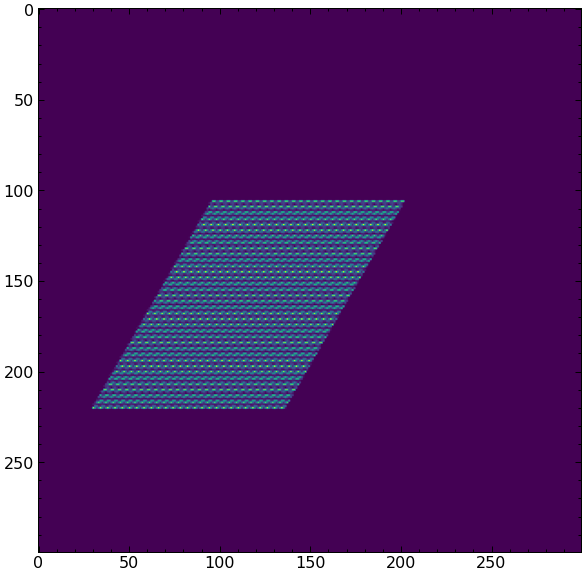

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(r[0][:][:][160])

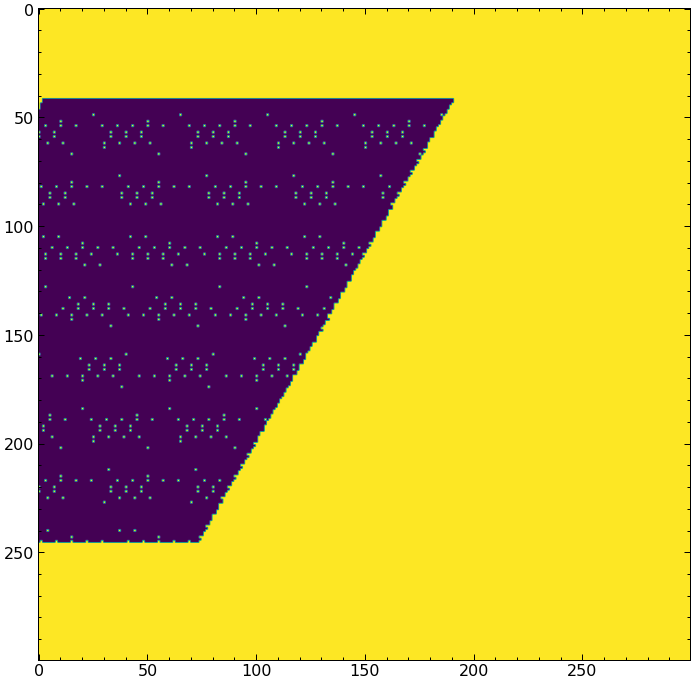

In [ ]:
grd=r[0]
x=r[1]
x=x[0]
rj= grd[:][:][250]==0
plt.figure(figsize=(12,12))
plt.imshow(rj)

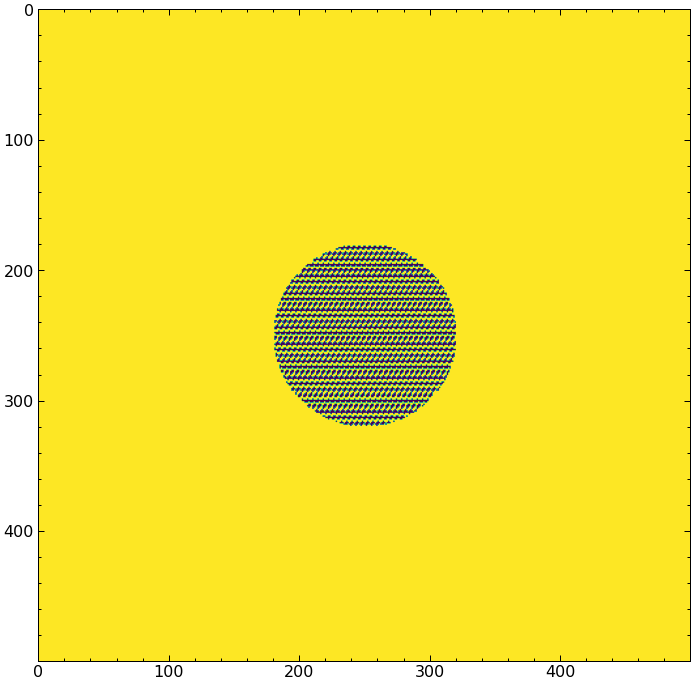

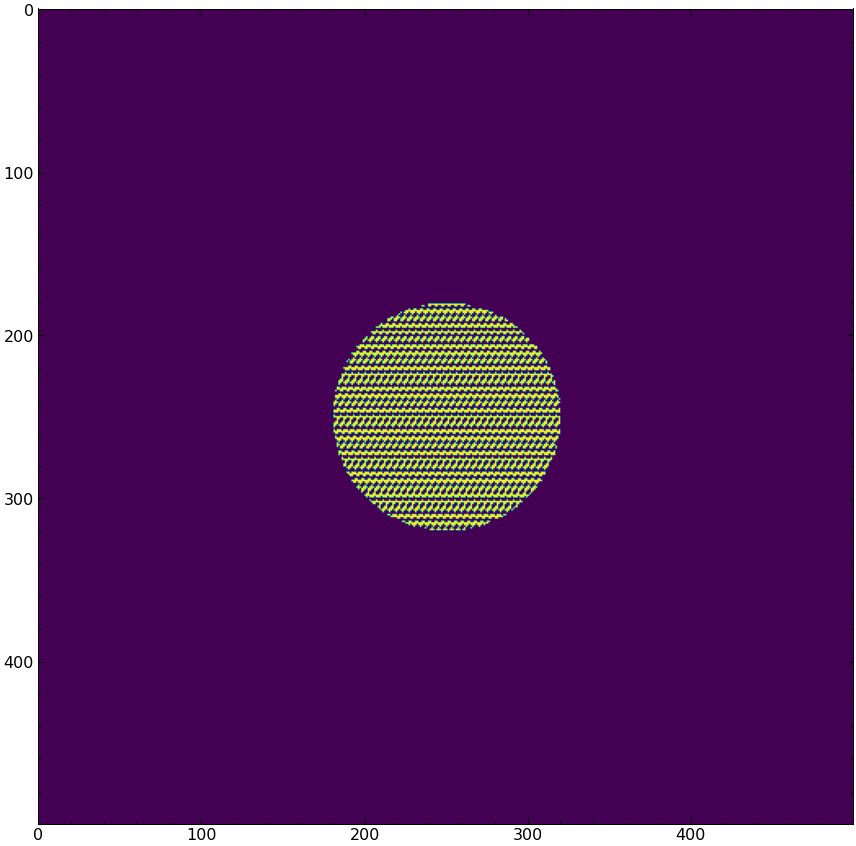

In [ ]:
grd=r[0]
x=r[1]
x=x[0]
rj= grd[:][:][260]>=0.0000251
plt.figure(figsize=(12,12))
plt.imshow(rj+grid2)
xv,yv=np.meshgrid((x+len(x)/2)*u.mm*0.01,(x+len(x)/2)*u.mm*0.01)
f=(yv-len(x)/(2*100)*u.mm)**2+(xv-len(x)/(2*100)*u.mm)**2
grid2= f>=(70*u.mm*0.01)**2
plt.figure(figsize=(15,15))
#plt.imshow(grid)
grid3=grid2+rj

for i in range(len(grid3)):
  j=0
  for j in range(len(grid3)):
    if (i-len(x)/2)**2+(j-len(x)/2)**2>=(70)**2:
      grid3[i][j]=0
plt.imshow(grid3)

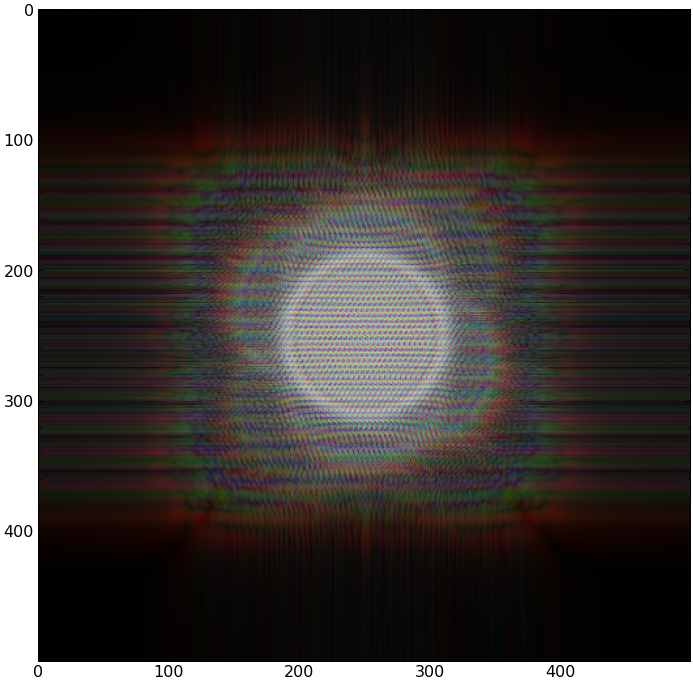

In [ ]:
Luz(grid3)

In [ ]:
r[1]

[array([-250., -249., -248., -247., -246., -245., -244., -243., -242.,
        -241., -240., -239., -238., -237., -236., -235., -234., -233.,
        -232., -231., -230., -229., -228., -227., -226., -225., -224.,
        -223., -222., -221., -220., -219., -218., -217., -216., -215.,
        -214., -213., -212., -211., -210., -209., -208., -207., -206.,
        -205., -204., -203., -202., -201., -200., -199., -198., -197.,
        -196., -195., -194., -193., -192., -191., -190., -189., -188.,
        -187., -186., -185., -184., -183., -182., -181., -180., -179.,
        -178., -177., -176., -175., -174., -173., -172., -171., -170.,
        -169., -168., -167., -166., -165., -164., -163., -162., -161.,
        -160., -159., -158., -157., -156., -155., -154., -153., -152.,
        -151., -150., -149., -148., -147., -146., -145., -144., -143.,
        -142., -141., -140., -139., -138., -137., -136., -135., -134.,
        -133., -132., -131., -130., -129., -128., -127., -126., -125.,
      